In [4]:
# Utility for computing MFCC features for a wav file

import numpy as np
import scipy as sp
from scipy.io import wavfile
import matplotlib.pyplot as plt
from collections import defaultdict
import sphfile

In [5]:
wav_file = "/home/apoorv/Projects/datasets/timit/TIMIT/TRAIN/DR1/FVMH0/SA1.WAV"

In [6]:
sf = sphfile.SPHFile(wav_file)

In [7]:
# samplerate, data = wavfile.read(wav_file)

In [8]:
PI = np.pi
def raised_cosine_window(a0, N):
    window = np.zeros(N+1) + a0 - (1 - a0) * np.cos(2*PI*np.arange(N+1)/(N * 1.0))
    return window

def hanning_window(N):
    return raised_cosine_window(0.5, N)

def hamming_window(N):
    return raised_cosine_window(0.54, N)

def compute_spectrogram(x: np.array, fs: int, window_ms: int, window_shift_ms: int, fft_window_len: int):
    if x.dtype == 'int16':
        x = x / 2**(16 - 1)
    
    # pre-emphasis
    x = x[1:] - 0.97 * x[:-1]

    window_len = int(window_ms * fs / 1000.0)
    window_shift = int(window_shift_ms * fs / 1000.0)

    window = hamming_window(window_len)
    x_windowed = np.lib.stride_tricks.sliding_window_view(x, window.shape)[::window_shift]
    x_windowed = x_windowed * window[np.newaxis, :]


    x_windowed_fft = np.fft.fft(x_windowed, fft_window_len, axis=-1)
    x_windowed_psd = 1/(fs * window_len) * np.absolute(x_windowed_fft)**2

    psd_one_sided = x_windowed_psd[:, :(window_len+1)//2]*2

    freqs = np.fft.fftfreq(window_len+1, 1/fs)[:(window_len+1)//2]

    num_frames = psd_one_sided.shape[0]
    frame_times = np.arange(num_frames) * (window_shift_ms / 1000.0)

    return psd_one_sided, freqs, frame_times

def plot_spectrogram(x: np.array, fs: int, window_ms: int, window_shift_ms: int, fft_window_len: int):
    psd, freqs, frame_times = compute_spectrogram(x, fs, window_ms, window_shift_ms, fft_window_len)

    # Create time arrays for both plots
    waveform_time = np.arange(len(x)) / fs
    spectrogram_time = frame_times
    
    # Create subplots that share the x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 6), sharex=True)
    
    # Plot spectrogram
    im = ax1.imshow(np.log10(psd.T), 
                    extent=[spectrogram_time[0], spectrogram_time[-1], 
                           freqs[0]/1000.0, freqs[-1]/1000.0],
                    aspect='auto', origin='lower')
    ax1.set_ylabel('Frequency (kHz)')
    ax1.set_title('Spectrogram')
    
    # Plot waveform
    ax2.plot(waveform_time, x/(2**15))
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title('Waveform')
    
    # Set common x-axis limits
    max_time = max(waveform_time[-1], spectrogram_time[-1])
    ax1.set_xlim(0, max_time)
    ax2.set_xlim(0, max_time)
    
    plt.tight_layout()
    plt.show()

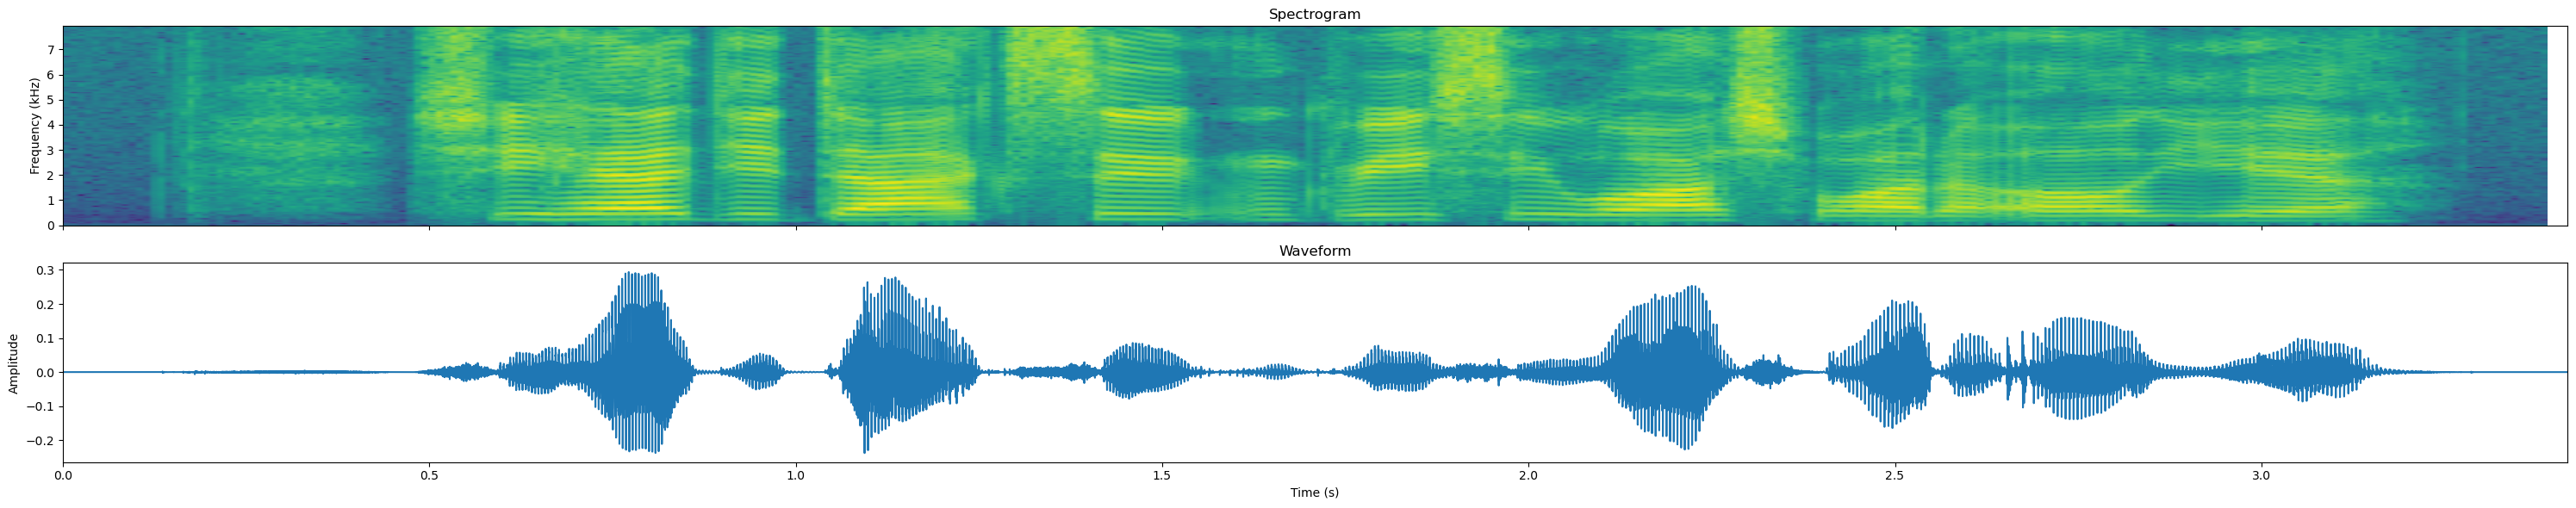

In [9]:
plot_spectrogram(sf.content, 16000, window_ms=20, window_shift_ms=10, fft_window_len=320)

In [10]:
def hz2mel(f):
    return 2595.0 * np.log10(1 + f/700.0)

def mel2hz(m):
    return 700.0 * (10**(m/2595.0) - 1)

def mel_filter_bank_centers(fs, num_filters: int = 40):
    low_freq_hz = 50 # 50 Hz
    high_freq_hz = fs//2

    low_freq_mel = hz2mel(low_freq_hz)
    high_freq_mel = hz2mel(high_freq_hz)

    diff_mel = high_freq_mel - low_freq_mel

    filter_bank_centers = []
    for i in range(num_filters + 2):
        m = low_freq_mel + diff_mel/(num_filters) * i
        filter_bank_centers.append(mel2hz(m))
    
    print(filter_bank_centers)
    return filter_bank_centers

def visualize_mel_filter_bank(fs, num_filters: int = 40):
    filter_bank_centers = mel_filter_bank_centers(fs, num_filters)

    freq = np.arange(50, fs//2, 1.0)

    filter_bank = defaultdict(list)
    plt.figure()
    for i in range(1, len(filter_bank_centers)-1):
        fbc = filter_bank_centers[i] * 1.0
        fbc_key = int(fbc)
        fbc_prev = filter_bank_centers[i-1] * 1.0
        fbc_next = filter_bank_centers[i+1] * 1.0
        for f in freq:
            if f < fbc_prev:
                filter_bank[fbc_key].append(0)
            elif f >= fbc_prev and f < fbc:
                r = (f - fbc_prev)/(fbc - fbc_prev)
                filter_bank[fbc_key].append(r)
            elif f == fbc:
                filter_bank[fbc_key].append(1.0)
            elif f > fbc and f <= fbc_next:
                r = (fbc_next - f)/(fbc_next - fbc)
                filter_bank[fbc_key].append(r)
            else:
                filter_bank[fbc_key].append(0)
        plt.plot(freq, filter_bank[fbc_key])
    return freq, filter_bank

def mel_filter_bank_coefficients(fs, num_filters, fft_bins):
    filter_bank_centers = mel_filter_bank_centers(fs, num_filters)

    filter_bank_coeff = []
    for i in range(1, len(filter_bank_centers)-1):
        fbc = filter_bank_centers[i] * 1.0
        fbc_prev = filter_bank_centers[i-1] * 1.0
        fbc_next = filter_bank_centers[i+1] * 1.0
        coeffs = []
        for f in fft_bins:
            if f < fbc_prev:
                r = 0
            elif f >= fbc_prev and f < fbc:
                r = (f - fbc_prev)/(fbc - fbc_prev)
            elif f > fbc and f <= fbc_next:
                r = (fbc_next - f)/(fbc_next - fbc)
            else:
                r = 0
            coeffs.append(r)
        filter_bank_coeff.append(coeffs)

    return np.array(filter_bank_coeff)



In [11]:
freq, filter_bank = visualize_mel_filter_bank(samplerate, 40)

NameError: name 'samplerate' is not defined

In [13]:
def compute_mfcc(x: np.array, fs: int, window_ms: int, window_shift_ms: int, fft_window_len: int, compute_delta: bool, compute_delta_delta: bool):
    psd, freqs, frame_times = compute_spectrogram(x, fs, window_ms, window_shift_ms, fft_window_len)
    filter_bank_coeffs = mel_filter_bank_coefficients(fs, 40, freqs)
    
    log_mel_psd = np.log10(psd @ filter_bank_coeffs.T)
    
    # compute the DCT (which is equivalent to the IFFT of psd.)
    mel_cepstrum = sp.fft.dct(log_mel_psd, type=2, axis=-1)

    mfcc_13 = mel_cepstrum[:, :13]
    if compute_delta:
        mfcc_delta = (mfcc_13[2:] - mfcc_13[:-2])/2.0
        if compute_delta_delta:
            mfcc_delta_delta = (mfcc_delta[2:] - mfcc_delta[:-2])/2.0
            mfcc = np.stack((mfcc_13[4:], mfcc_delta[2:], mfcc_delta_delta), axis=-1).reshape(mfcc_delta_delta.shape[0], 39)
            return mfcc
        mfcc = np.stack((mfcc_13[2:], mfcc_delta), axis=-1).reshape(mfcc_delta.shape[0], 26)
        return mfcc
    return mfcc_13


In [14]:
mfcc = compute_mfcc(sf.content, 16000, 20, 10, 512, True, True)

[49.99999999999998, 97.393540317399, 147.78194418655397, 201.35446118944515, 258.3122998516445, 318.8693833445489, 383.2531529414868, 451.70542224532966, 524.483285395931, 601.8600826684556, 684.126427089202, 771.5912959247081, 864.583191143563, 963.4513732094127, 1068.5671728390573, 1180.3253856523588, 1299.1457549520173, 1425.4745482022518, 1559.786233127357, 1702.5852597252565, 1854.4079548889601, 2015.82453675178, 2187.441256321816, 2369.902674449296, 2563.8940826786343, 2770.1440770775002, 2989.427294709709, 3222.5673230296247, 3470.4397931252465, 3733.975668427603, 4014.1647412382563, 4312.059350207239, 4628.778332723564, 4965.511227062785, 5323.522740074091, 5704.157497186719, 6108.84509257591, 6539.105458455802, 6996.554573665439, 7482.910532988209, 8000.000000000002, 8549.765067681832]


In [15]:
mfcc.shape

(336, 39)

In [16]:
mfcc

array([[-1.05800101e+03,  5.31479291e+00,  3.06987835e+00, ...,
         6.42660936e+00,  3.60558694e+00,  1.49928766e+00],
       [-1.05816744e+03,  1.27952766e+00, -1.03084358e+00, ...,
         9.57695546e-03,  3.38102301e-01, -3.75821741e-01],
       [-1.06286200e+03, -2.43049407e+00, -3.87264349e+00, ...,
        -6.05684056e-01, -3.51614671e+00, -3.56086683e+00],
       ...,
       [-1.05528387e+03,  3.13155120e+00,  6.81956632e-01, ...,
         1.69838059e+00, -1.87796841e+00, -2.00352505e+00],
       [-1.04975007e+03,  7.01730982e+00,  2.02188276e+00, ...,
         2.60498334e+00,  3.19680613e+00,  4.00072540e+00],
       [-1.05739117e+03, -1.05365072e+00, -2.09260096e+00, ...,
        -8.48991321e-01, -1.27368596e+00,  3.02141228e-01]])

In [17]:
from mfcc import MfccConfig, MfccComputer, WindowType

In [18]:
mfcc_config = MfccConfig(fs=16000,
                         window_ms=20,
                         window_shift_ms=10,
                         window_type=WindowType.HAMMING,
                         fft_window_len=512,
                         num_mel_filters=40,
                         low_freq_hz=50,
                         compute_delta=True,
                         compute_delta_delta=False)
mfcc_computer = MfccComputer(mfcc_config)

### Training Data batcher

In [19]:
import tensorflow as tf

train_tfr = "/home/apoorv/Projects/datasets/timit/TIMIT/train_processed/data.tfrecord"
dataset = tf.data.TFRecordDataset(filenames = [train_tfr])
dataset

2025-09-13 13:11:22.371267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-13 13:11:22.380739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-13 13:11:22.383954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-13 13:11:22.392545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1757749283.964986  1927

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [20]:
def parse_example_fn(example, mfcc_feat_dim):
    """Parse a single TFRecord example."""
    feature_description = {
        'input_seq': tf.io.FixedLenFeature([], tf.string),
        'input_paddings': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.VarLenFeature(tf.int64),
        'label_paddings': tf.io.VarLenFeature(tf.float32),
    }
    
    # Parse the input tf.train.Example proto using the dictionary above
    parsed_example = tf.io.parse_single_example(example, feature_description)
    
    # Decode the bytes back to the original tensor shape
    input_seq = tf.io.decode_raw(parsed_example['input_seq'], tf.float32)
    input_seq = tf.reshape(input_seq, [-1, mfcc_feat_dim])
    
    input_paddings = parsed_example['input_paddings']
    label = parsed_example['label']
    label_paddings = parsed_example['label_paddings']
    
    return {
        'input_seq': input_seq,
        'input_paddings': input_paddings,
        'label': label,
        'label_paddings': label_paddings
    }


In [21]:
from functools import partial
f = partial(parse_example_fn, mfcc_feat_dim = 13)

for batch in dataset.map(f).batch(4):
    break

In [22]:
print(batch['input_seq'].shape, batch['input_paddings'].shape, batch['label'].shape, batch['label_paddings'].shape)

(4, 777, 13) (4, 777) (4, 75) (4, 75)


In [23]:
import librosa

In [31]:
y = sf.content
y = y / y.max()

lr_mfcc = librosa.feature.mfcc(y=y, sr=16000, n_mfcc=39, n_fft=512, hop_length=160, win_length=320, window="hamming")
lr_mfcc = lr_mfcc.transpose(1, 0)

In [32]:
lr_mfcc.shape

(342, 39)

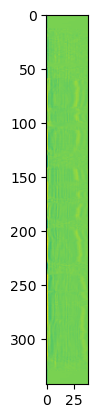

In [35]:
plt.imshow(lr_mfcc)

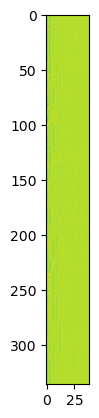

In [36]:
plt.imshow(mfcc)

In [50]:
import jax.numpy as jnp
import numpy as np

def _flip_input(x_btd, lengths_b):
    b, t, d = x_btd.shape
    indices = np.tile(np.arange(t)[None, :], (b, 1))
    reversed_indices = lengths_b - 1 - indices
    valid_mask = indices < lengths_b
    final_indices = np.where(valid_mask, reversed_indices, indices)
    batch_idx = np.arange(b)[:, None]
    return x_btd[batch_idx, final_indices]

In [51]:
b, t, d = 2, 8, 2
x_btd = np.arange(b * t * d).reshape((b, t, d))

In [52]:
x_btd

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15]],

       [[16, 17],
        [18, 19],
        [20, 21],
        [22, 23],
        [24, 25],
        [26, 27],
        [28, 29],
        [30, 31]]])

In [53]:
x_btd.shape

(2, 8, 2)

In [54]:
lengths_b = np.array([[3], [5]])

In [55]:
final_indices = _flip_input(x_btd, lengths_b)

In [56]:
final_indices

array([[[ 4,  5],
        [ 2,  3],
        [ 0,  1],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15]],

       [[24, 25],
        [22, 23],
        [20, 21],
        [18, 19],
        [16, 17],
        [26, 27],
        [28, 29],
        [30, 31]]])